# Have functions in scripts
# Final code presentation in notebook
# Have testing implementation set up, even if not great tests
# Have Travis set up
# Try different data sets: dense data, spread data, more or less points, smaller or larger uncertainties

In [1]:
import astropy.units as u
import astropy.constants as cons
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Defining the true parameters of the system
mstar=1.*cons.M_sun #Stellar mass [kg]
mplanet=5*cons.M_jup #Planet mass [kg]
a=2.*cons.au #Semimajor axis [m]
distance_to_star=5*u.pc #Earth-system distance [m]
mu=cons.G*(mstar+mplanet)
T=np.sqrt(4*np.pi**2.*a**3./mu) #Period [s]
e=.66 #Eccentricity
n=2.*np.pi/T #Mean motion
times=np.linspace(0, T, 25) #Times to sample from
tau=0 #Time/Epoch of Pericentre/Periastron Passage (should be in BJD?)
mean_anomalies=n*(times-tau) #Mean anomaly

In [3]:
rs=[] #Star-planet distance
cos_true_anomalies=[]
true_anomalies=[] #True anomaly (angle around orbit)

#Iterative scheme to solve Kepler's Eq. as a function of time
#described on Solar System Dynamics pg 36(Murray, Dermott)
for i in range(len(times)):
    k=0.85 #Suggested by Murray&Dermott
    mean_anomaly=mean_anomalies[i]
    eccentric_anomaly_0=mean_anomaly+np.sign(np.sin(mean_anomaly*u.rad))*k*e #First guess
    eccentric_anomaly_i=eccentric_anomaly_0
    
    for i in range(5): #For low eccentricities, takes very few (~1) iterations to converge
        fppp=e*np.cos(eccentric_anomaly_i*u.rad)
        fpp=e*np.sin(eccentric_anomaly_i*u.rad)
        fp=1.-e*np.cos(eccentric_anomaly_i*u.rad)
        f=eccentric_anomaly_i-e*np.sin(eccentric_anomaly_i*u.rad)-mean_anomaly
        d1=-f/fp
        d2=-f/(fp+.5*d1*fpp)
        d3=-f/(fp+.5*d2*fpp+(1/6.)*d2**2.*fppp)
        
        eccentric_anomaly_next=eccentric_anomaly_i+d3
        eccentric_anomaly_i=eccentric_anomaly_next
   
    cos_true_anomaly=(np.cos(eccentric_anomaly_next*u.rad)-e)/(1.-e*np.cos(eccentric_anomaly_next*u.rad))
    r=a*(1.-e**2.)/(1.+e*cos_true_anomaly)
    true_anomaly=2.*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(eccentric_anomaly_next*u.rad/2.))
    
    rs.append(r.value)
    cos_true_anomalies.append(cos_true_anomaly)
    true_anomalies.append(true_anomaly.value)

    for ar in [rs, cos_true_anomalies, true_anomalies]:
    ar=np.array(ar)

In [4]:
#Attach unit to array
rs=rs*u.m 
true_anomalies=true_anomalies*u.rad

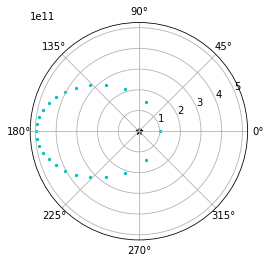

In [5]:
#Plotting in polar coords
ax=plt.subplot(111, polar=True)
ax.scatter(0,0, color='k', marker='*', s=50)
for i, t in enumerate(times):
    ax.scatter(true_anomalies[i], rs[i], color='c', s=5)
plt.show()

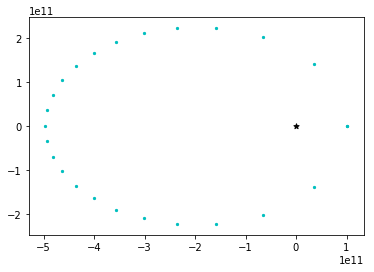

In [6]:
#Plotting in cartesian coords
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times):
    ax.scatter(rs[i]*np.cos(true_anomalies[i]), rs[i]*np.sin(true_anomalies[i]), color='c', s=5)
plt.show()

In [7]:
t_yrs=[t.to('year') for t in times]

In [8]:
def mas_unc_to_m_unc(dist, mas_unc):
    ''' Converts mas uncertainties to meters at the plane of the system.'''
    radians_unc=mas_unc.to('rad')
    m_unc=np.tan(radians_unc)*dist
    return m_unc.to('m')

#Paper I'm imitating (Wang et al. 2016: 1607.05272) has ~1mas uncertainties on position, ~.2degree uncertainties on position angle
#I use larger uncertainties, will make an argument of a future function
sigma_true_anomaly=(1*u.deg).to('rad')
sigma_r=mas_unc_to_m_unc(distance_to_star, 10*u.mas) 


#How do I incorporate mass as an observable with uncertainties
sigma_mass=.05*mstar
sigma_dist=.01*distance_to_star

In [9]:
#Add gaussian noise to the data
noisy_rs=rs+sigma_r*np.random.normal(loc=0, size=len(rs))
noisy_true_anomalies=true_anomalies+sigma_true_anomaly*np.random.normal(loc=0, size=len(true_anomalies))
noisy_mass=mstar+sigma_mass*np.random.normal(loc=0, size=1)
noisy_distance=distance_to_star+sigma_dist*np.random.normal(loc=0, size=1)

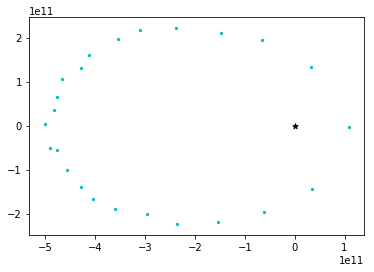

In [10]:
#Cartesian plot of data with gaussian noise
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times[:-1]):
    ax.scatter(noisy_rs[i]*np.cos(noisy_true_anomalies[i]), noisy_rs[i]*np.sin(noisy_true_anomalies[i]), color='c', s=5)
plt.show()

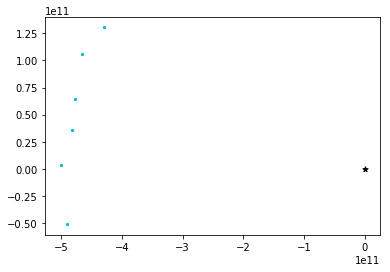

In [11]:
data=[noisy_true_anomalies[8:14], noisy_rs[8:14]]
info=[times[8:14], sigma_true_anomaly, sigma_r]
#Cartesian plot of noisy data the mcmc will run on
f,ax=plt.subplots(1,1)
ax.scatter(0,0, marker='*', color='k', s=30)
for i, t in enumerate(times[8:14]):
    ax.scatter(data[1][i]*np.cos(data[0][i]), data[1][i]*np.sin(data[0][i]), color='c', s=5)
plt.show()

# To debug: 
 test lnlike for true values
 
 plot lnlike for different noise realizations
 
    on average this should be centered at the truth
    
 test on the pos value which is minimization plus random noise

In [12]:
def lnlike(pars, data, info):
    mpm, e, a, time_periastron, arg_periastron = pars #Unpack parameters
    mpm=mpm*u.kg #Total mass
    a=a*u.m #Semimajor axis
    T=np.sqrt(4.*np.pi**2.*a**3./(cons.G*mpm)) #Period
    times, sigma_theta, sigma_r = info #Unpacking info (time values, uncertainties)
    thetas, rs=data #Unpacking data
    mean_anomalies=(2.*np.pi)*(times-time_periastron*u.s)/T #Calculating mean anomalies
    #FAIRLY CERTAIN I'M NOT HANDLING time_periastron CORRECTLY
    chis=np.zeros(len(times)*2) #For each time, two distances to calculate
    for i in range(len(times)):
        k=0.85
        mean_anomaly=mean_anomalies[i]
        eccentric_anomaly_0=mean_anomaly+np.sign(np.sin(mean_anomaly*u.rad))*k*e
        eccentric_anomaly_i=eccentric_anomaly_0
        for j in range(10):
            fppp=e*np.cos(eccentric_anomaly_i*u.rad)
            fpp=e*np.sin(eccentric_anomaly_i*u.rad)
            fp=1.-e*np.cos(eccentric_anomaly_i*u.rad)
            f=eccentric_anomaly_i-e*np.sin(eccentric_anomaly_i*u.rad)-mean_anomaly
            d1=-f/fp
            d2=-f/(fp+.5*d1*fpp)
            d3=-f/(fp+.5*d2*fpp+(1/6.)*d2**2.*fppp)
            eccentric_anomaly_next=eccentric_anomaly_i+d3
            eccentric_anomaly_i=eccentric_anomaly_next
        cos_true_anomaly=(np.cos(eccentric_anomaly_next*u.rad)-e)/(1.-e*np.cos(eccentric_anomaly_next*u.rad))
        cos_true_anomalies.append(cos_true_anomaly)
        true_r=a*(1.-e**2.)/(1.+e*cos_true_anomaly)
        #true_radii.append(r)
        true_anomaly=2.*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(eccentric_anomaly_next*u.rad/2.))
        #true_anoms.append(true_anomaly)
        chis[2*i]=(thetas[i]-true_anomaly)/sigma_theta
        chis[2*i+1]=(rs[i]-true_r)/sigma_r
    chis=np.array(chis)
    return -0.5*(np.sum(chis*chis))

In [13]:
#generate first guess
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
#op.minimize(function, [first guess], args=(data, info))
result = op.minimize(nll, [(noisy_mass+mplanet).value, e, a.value, 0, 0], args=(data, info))
mpmm, em, am, taum, argm = result["x"]

In [ ]:
#Flat priors in each parameter, inspired by those used for Beta Pic b in (Wang et al. 2016: 1607.05272)
def lnprior(pars):
    mpm, e, a, time_periastron, arg_periastron = pars
    if (0 < mpm < 6*cons.M_sun.value) and (0.0001 < e < 0.99) and (1*cons.au.value < a < 20*cons.au.value) and (-1 < time_periastron < 1) and (-2*np.pi < arg_periastron < 2*np.pi):
        return 0.0
    return -np.inf

In [ ]:
def lnprob(pars, data, info):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(pars, data, info)

In [ ]:
ndim, nwalkers = 5, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data, info))

In [ ]:
sampler.run_mcmc(pos, 50)

In [ ]:
f, axs=plt.subplots(5,1, figsize=(6,12))
for i, ax in enumerate(f.axes):
    for j in range(sampler.chain.shape[0]):
        ax.plot(sampler.chain[j,:,i], color='k', alpha=0.2)
plt.show()

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
mpmm, em, am, taum, argm

In [ ]:
#import corner
#fig = corner.corner(samples[:,1:], labels=["$e$", "$a$", "$\tau$", "$\varpi$"])
#plt.savefig('mcmctest.pdf')

In [ ]:
for i in range(5):
    print(samples[:,i].min(), samples[:,i].max())